### Import the libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_auc_score,confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords as st
import re
from datetime import datetime

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Import the dataframes

In [3]:
al=pd.read_csv("alexa.csv")
gh=pd.read_csv("googlehome.csv")

In [4]:
al.shape

(2707, 111)

In [5]:
al=al.drop_duplicates()

In [6]:
al.shape

(1554, 111)

In [7]:
al.tail()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,subreddit_name_prefixed,hidden,pwls,link_flair_css_class,downs,thumbnail_height,hide_score,name,quarantine,link_flair_text_color,upvote_ratio,author_flair_background_color,subreddit_type,ups,total_awards_received,media_embed,thumbnail_width,author_flair_template_id,is_original_content,user_reports,secure_media,is_reddit_media_domain,is_meta,category,secure_media_embed,link_flair_text,can_mod_post,score,approved_by,author_premium,thumbnail,edited,author_flair_css_class,author_flair_richtext,gildings,content_categories,is_self,mod_note,created,link_flair_type,wls,removed_by_category,banned_by,author_flair_type,domain,allow_live_comments,selftext_html,likes,suggested_sort,banned_at_utc,view_count,archived,no_follow,is_crosspostable,pinned,over_18,all_awardings,awarders,media_only,can_gild,spoiler,locked,author_flair_text,treatment_tags,visited,removed_by,num_reports,distinguished,subreddit_id,mod_reason_by,removal_reason,link_flair_background_color,id,is_robot_indexable,report_reasons,author,discussion_type,num_comments,send_replies,whitelist_status,contest_mode,mod_reports,author_patreon_flair,author_flair_text_color,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,post_hint,preview,link_flair_template_id,author_cakeday,crosspost_parent_list,crosspost_parent,media_metadata,poll_data
2700,NaN,amazonecho,Echo is white. \n\nLooking for home that is re...,t2_4s5ui,False,NaN,0,False,Looking to trade Echo for Google Home,[],r/amazonecho,False,6,question,0,NaN,False,t3_fmxfl6,False,dark,0.13,NaN,public,0,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Question,False,0,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1.584899e+09,text,6,NaN,NaN,text,self.amazonecho,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_34em3,NaN,NaN,NaN,fmxfl6,True,NaN,ErrorProxy,NaN,0,True,all_ads,False,[],False,NaN,/r/amazonecho/comments/fmxfl6/looking_to_trade...,all_ads,False,https://www.reddit.com/r/amazonecho/comments/f...,104588,1.584870e+09,0,NaN,False,NaN,NaN,07d4539a-069b-11e8-95e0-0e424b73042e,NaN,NaN,NaN,NaN,NaN
2701,NaN,amazonecho,Hello.\n\nI Just wanted to share how I used sw...,t2_232zni2t,False,NaN,0,False,How to control electric adjustable bed using A...,[],r/amazonecho,False,6,NaN,0,78.0,False,t3_fm69k9,False,dark,0.95,NaN,public,83,0,{},140.0,NaN,False,[],NaN,False,False,NaN,{},NaN,False,83,NaN,False,https://a.thumbs.redditmedia.com/bq05V235tuY4A...,1584817302.0,NaN,[],{},NaN,True,NaN,1.584780e+09,text,6,NaN,NaN,text,self.amazonecho,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,False,False,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_34em3,NaN,NaN,NaN,fm69k9,True,NaN,thunderwear1,NaN,4,True,all_ads,False,[],False,NaN,/r/amazonecho/comments/fm69k9/how_to_control_e...,all_ads,False,https://www.reddit.com/r/amazonecho/comments/f...,104588,1.584751e+09,0,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,"{'p6kndft69xn41': {'status': 'valid', 'e': 'Im...",NaN
2702,NaN,amazonecho,i have my show 5 setup to stay on big clock at...,t2_ketlx,False,NaN,0,False,Echo Show 5 not staying on Big Clock and Do No...,[],r/amazonecho,False,6,NaN,0,NaN,False,t3_fmlspz,False,dark,0.70,NaN,public,4,0,{},NaN,NaN,False,[],NaN,False,False,NaN,{},Technical Issue,False,4,NaN,False,self,False,NaN,[],{},NaN,True,NaN,1.584851e+09,text,6,NaN,NaN,text,self.amazonecho,False,"&lt;!-- SC_OFF --&gt;&lt;div class=""md""&gt;&lt...",NaN,confidence,NaN,NaN,False,True,False,False,False,[],[],False,False,False,False,NaN,[],False,NaN,NaN,NaN,t5_34em3,NaN,NaN,NaN,fmlspz,True,NaN,willydynamite1,NaN,2,True,all_ads,False,[],False,NaN,/r/amazonecho/comments/fmlspz/echo_show_5_not_...,all_ads,False,https://www.reddit.com/r/amazonecho/comments/f...,10458

In [8]:
print(al.columns)

Index(['approved_at_utc', 'subreddit', 'selftext', 'author_fullname', 'saved',
       'mod_reason_title', 'gilded', 'clicked', 'title', 'link_flair_richtext',
       ...
       'media', 'is_video', 'post_hint', 'preview', 'link_flair_template_id',
       'author_cakeday', 'crosspost_parent_list', 'crosspost_parent',
       'media_metadata', 'poll_data'],
      dtype='object', length=111)


In [9]:
al['created_date']=[datetime.fromtimestamp(i).strftime('%Y-%m-%d') for i in al['created']]
al['created_date'] = al['created_date'].astype("datetime64")

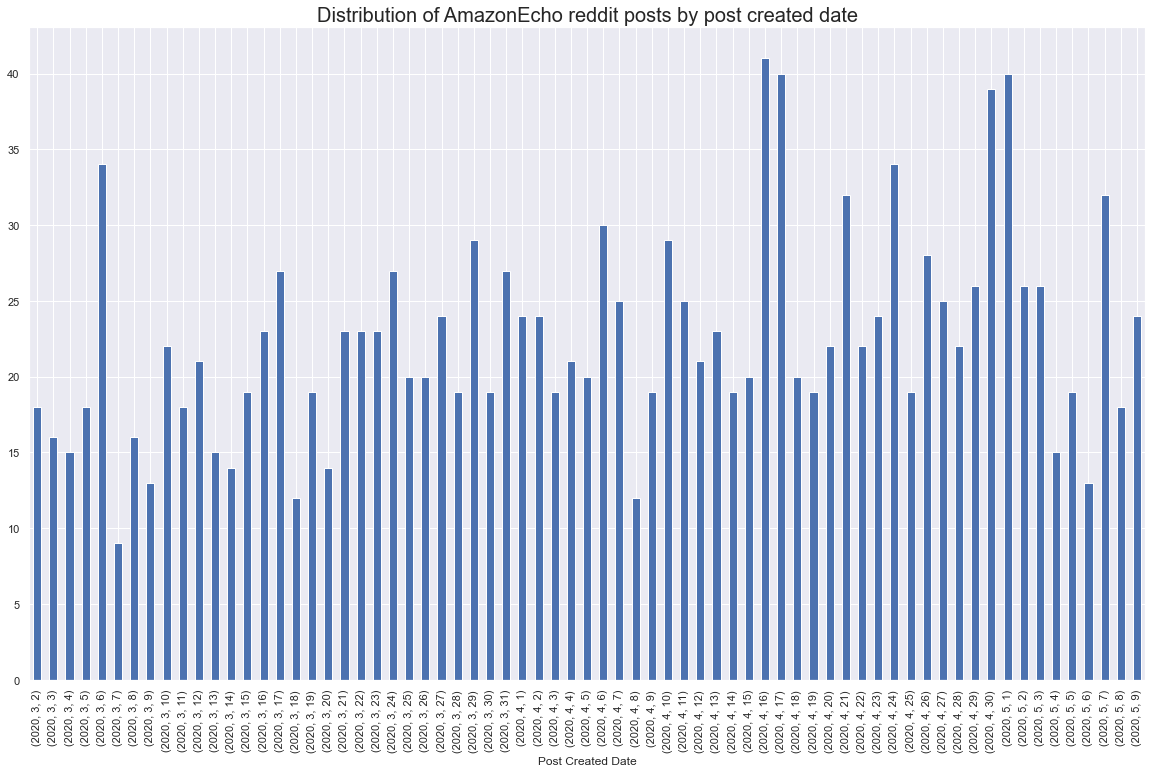

In [10]:
sns.set(style="darkgrid")
plt.figure(figsize = (20, 12)) 
al['subreddit'].groupby([al['created_date'].dt.year, al['created_date'].dt.month, al['created_date'].dt.day]).count().plot(kind="bar");
plt.title('Distribution of AmazonEcho reddit posts by post created date',fontsize=20);
plt.xlabel('Post Created Date');

In [11]:
Avg_post_per_day = round(len(al['subreddit'])/len(al['created_date'].unique()),0)
Avg_post_per_day

23.0

In [12]:
len(al['author_fullname'].unique())

898

#### Observation:

- The Amazon Echo subreddit gathered an average of 23 posts per day for the period gathered between (2nd Mar - 9th May 2020) with 898 unique authors.

In [13]:
al=al[['subreddit','selftext','title']]

In [14]:
al.shape

(1554, 3)

In [15]:
al.isnull().sum()

subreddit      0
selftext     185
title          0
dtype: int64

In [16]:
al['selftext'].fillna("",inplace=True)

In [17]:
al['subreddit'].unique()

array(['amazonecho'], dtype=object)

In [18]:
al=al.assign(text=al['selftext'].astype(str)+ " "+ al['title'].astype(str))

In [19]:
al.head()

,subreddit,selftext,title,text
0,amazonecho,"Post your requested features here, and vote on...",Monthly Echo Feature Request Thread,"Post your requested features here, and vote on..."
1,amazonecho,I can't use the speakers on my laptop so I con...,Anyone know how to get Echo to stop announcing...,I can't use the speakers on my laptop so I con...
2,amazonecho,,Alexa keeps doing this and won't respond to vo...,Alexa keeps doing this and won't respond to v...
3,amazonecho,I'm new to how Echo's work so maybe this is ob...,Help - Echo plays Italian Podcast when I ask i...,I'm new to how Echo's work so maybe this is ob...
4,amazonecho,"TL;DR Amazon Echo for older grandparents, reco...",Echo -make it work for Grandparents,"TL;DR Amazon Echo for older grandparents, reco..."


In [20]:
al.drop(['selftext','title'],axis=1,inplace=True)

In [21]:
al.drop_duplicates(inplace=True)

In [22]:
al.shape

(988, 2)

In [23]:
al

,subreddit,text
0,amazonecho,"Post your requested features here, and vote on..."
1,amazonecho,I can't use the speakers on my laptop so I con...
2,amazonecho,Alexa keeps doing this and won't respond to v...
3,amazonecho,I'm new to how Echo's work so maybe this is ob...
4,amazonecho,"TL;DR Amazon Echo for older grandparents, reco..."
5,amazonecho,"Hi,\n\nI'm losing my mind here. My echo has be..."
6,amazonecho,Just bought them a dot so I can send my mom me...
7,amazonecho,I'm looking to upgrade my echo dot. I have som...
8,amazonecho,Anyone else having this issue..... My Echo 2n...
9,amazonecho,"Hi, I'm trying to program a Lasko 2551 Fan to..."


### EDA - Generate a WordCloud for pre-processed Alexa file

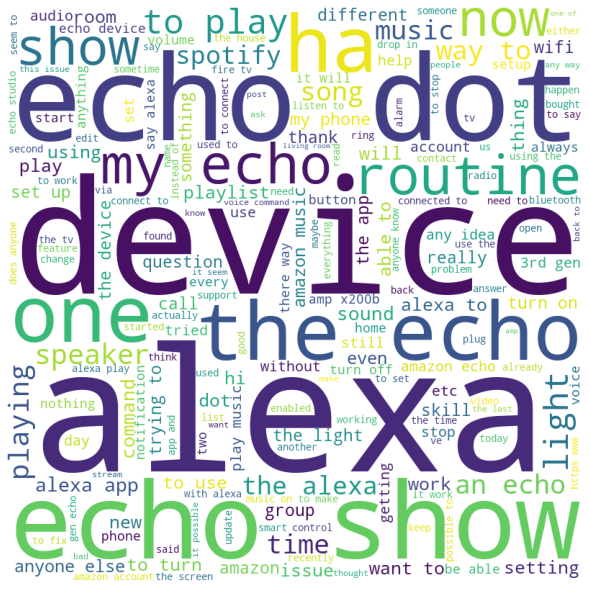

In [24]:
al_text=[i for i in al['text']]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in al_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### Observation:
- Keywords like alexa, device, echo and dot are prominent and we will attempt to add them to the stop words when building our model

In [25]:
al['text'][986]

"Hello,\n\nI've had my echo devices (two of them) for a little over a year. Two weeks ago my reminders stopped giving me push notifications. I didn't change anything in my settings, didn't lose power or internet, and didn't change phones or devices.\n\nI've looked at all the settings in the Alexa App on my iPhone and they are all correct still, as well as my overall device settings for notifications are correct.\n\nIs there any fix for this? Push notifications for reminders stopped?"

In [26]:
gh=gh.drop_duplicates()

In [27]:
gh.shape

(1326, 110)

In [28]:
gh['created_date']=[datetime.fromtimestamp(i).strftime('%Y-%m-%d') for i in gh['created']]
gh['created_date'] = gh['created_date'].astype("datetime64")

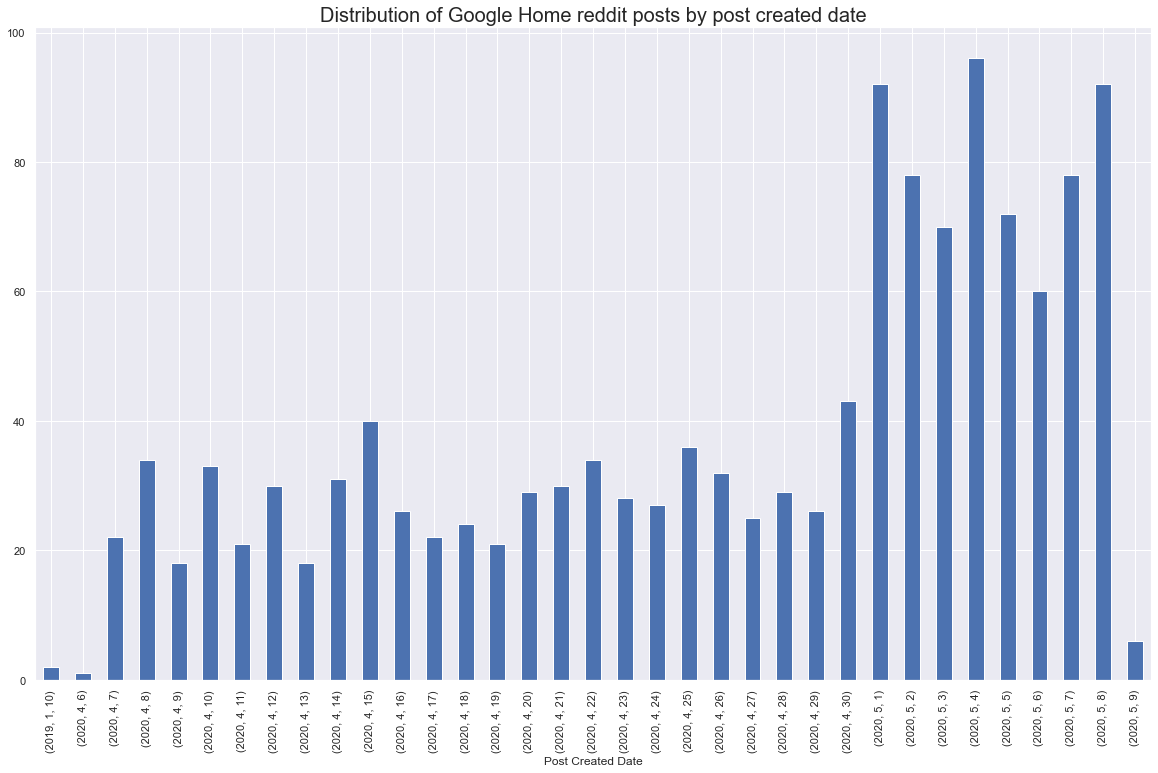

In [29]:
sns.set(style="darkgrid")
plt.figure(figsize = (20, 12)) 
gh['subreddit'].groupby([gh['created_date'].dt.year, gh['created_date'].dt.month, gh['created_date'].dt.day]).count().plot(kind="bar");
plt.title('Distribution of Google Home reddit posts by post created date',fontsize=20);
plt.xlabel('Post Created Date');

In [30]:
Avg_post_per_day = round(len(gh['subreddit'])/len(gh['created_date'].unique()),0)
Avg_post_per_day

38.0

In [31]:
len(gh['author_fullname'].unique())

921

#### Observation:

- The Google Home subreddit gathered an average of 38 posts per day for the period gathered between (1 Jan 2019 - 9th May 2020) with 921 unique authors.

In [32]:
gh=gh[['subreddit','selftext','title']]

In [33]:
gh.isnull().sum()

subreddit      0
selftext     242
title          0
dtype: int64

In [34]:
gh['selftext'].fillna("",inplace=True)

In [35]:
gh['subreddit'].unique()

array(['googlehome'], dtype=object)

#### Combine the values in the 2 columns (selftext + title)  and assign it to a new column (text) 

In [36]:
gh=gh.assign(text=gh['selftext'].astype(str)+ " "+ gh['title'].astype(str))

In [37]:
gh.head()

,subreddit,selftext,title,text
0,googlehome,[\[FAQ - Frequently Asked Questions\]](https:/...,FAQ: Please read the subreddit FAQ before post...,[\[FAQ - Frequently Asked Questions\]](https:/...
1,googlehome,Do you want to liberate your Google so it can ...,My Google has Coronavirus! - Monthly Rants and...,Do you want to liberate your Google so it can ...
2,googlehome,,I think I found a way around it until it works...,I think I found a way around it until it work...
3,googlehome,"Hey Google, set a timer for 1 hour and 30 minu...",Oh my god how do you set a timer for 1 hour an...,"Hey Google, set a timer for 1 hour and 30 minu..."
4,googlehome,"It all started last night, when my Home Mini w...",Google Home Mini muted itself,"It all started last night, when my Home Mini w..."


In [38]:
gh.drop(['selftext','title'],axis=1,inplace=True)

In [39]:
gh.drop_duplicates(inplace=True)

In [40]:
gh.shape

(998, 2)

### EDA - Generate a WordCloud for pre-processed Googlehome file

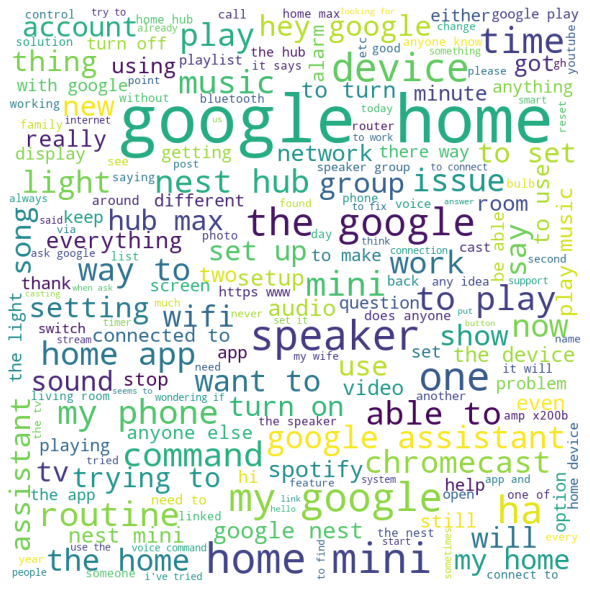

In [41]:
gh_text=[i for i in gh['text']]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in gh_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

#### Observation:
- Keywords like google, home and mini are prominent and we will attempt to add them to the stop words when building our model

### Merging the 2 datasets

In [42]:
df=al.append(gh)

In [43]:
df.shape

(1986, 2)

In [44]:
df.columns=['label','message']

In [45]:
df.head()

,label,message
0,amazonecho,"Post your requested features here, and vote on..."
1,amazonecho,I can't use the speakers on my laptop so I con...
2,amazonecho,Alexa keeps doing this and won't respond to v...
3,amazonecho,I'm new to how Echo's work so maybe this is ob...
4,amazonecho,"TL;DR Amazon Echo for older grandparents, reco..."


### Label the 2 Classes (GoogleHome =1 and Alexa =0)

In [46]:
df['label'] = df['label'].map({'amazonecho': 0, 'googlehome': 1})
df.head()

,label,message
0,0,"Post your requested features here, and vote on..."
1,0,I can't use the speakers on my laptop so I con...
2,0,Alexa keeps doing this and won't respond to v...
3,0,I'm new to how Echo's work so maybe this is ob...
4,0,"TL;DR Amazon Echo for older grandparents, reco..."


In [47]:
df.isnull().sum()

label      0
message    0
dtype: int64

### EDA - Generate a WordCloud for combined data file

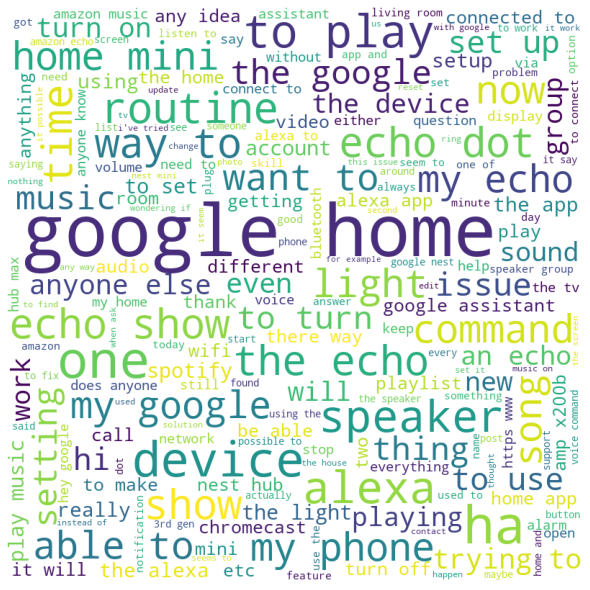

In [48]:
df_text=[i for i in df['message']]
comment_words = '' 
stopwords = set(STOPWORDS) 
  
for val in df_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Set up our data for modeling

In [49]:
X = df[['message']]
y = df['label']

### Review distribution of the 2 Classes

In [50]:
y.value_counts(normalize=True)

1    0.502518
0    0.497482
Name: label, dtype: float64

In [51]:
y.value_counts()

1    998
0    988
Name: label, dtype: int64

#### Observation:
- Both classes are quite equally distributed
- Baseline_score = 0.502

In [52]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    random_state = 42,
                                                    stratify=y)

### Instantiate Stemming
- **Stemming** is a form of shortening words so we can combine similar forms of the same word.

In [53]:
p_stemmer=PorterStemmer()

### Adding new Stop Words to the nltk corpus stopwords list  

In [54]:
st = nltk.corpus.stopwords.words('english')
newStopWords = ['googl','gh', 'google', 'home', 'alexa', 'echo', 'dot','amazon']
st.extend(newStopWords)

In [55]:
def review_to_words(raw_review):
  
    review_text = BeautifulSoup(raw_review).get_text() 
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    words = letters_only.lower().split()
    stops = set(st)
    meaningful_words = [w for w in words if w not in stops]
    meaningful_words=[p_stemmer.stem(w) for w in words]
    return(" ".join(meaningful_words))

In [56]:
# Get the number of messages based on the dataframe size.
total_messages = X.shape[0]
print(f'There are {total_messages} messages.')

There are 1986 messages.


In [57]:
# Initialize an empty list to hold the clean messages.
clean_train_message = []
clean_test_message = []

print("Cleaning and parsing the training set messages...")

# Instantiate counter.
j = 0

# For every message in our training set...
for train_message in X_train['message']:
    
    # Convert messages to words, then append to clean_train_message.
    clean_train_message.append(review_to_words(train_message))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Message {j + 1} of {total_messages}.')
    
    j += 1

# Do the same for the testing set.
print("Cleaning and parsing the testing set messages...")

# For every message in our testing set...
for test_message in X_test['message']:
    
    # Convert messages to words, then append to clean_train_message.
    clean_test_message.append(review_to_words(test_message))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'Message {j + 1} of {total_messages}.')
        
    j += 1

Cleaning and parsing the training set messages...
Message 100 of 1986.
Message 200 of 1986.
Message 300 of 1986.
Message 400 of 1986.
Message 500 of 1986.
Message 600 of 1986.
Message 700 of 1986.
Message 800 of 1986.
Message 900 of 1986.
Message 1000 of 1986.
Message 1100 of 1986.
Message 1200 of 1986.
Message 1300 of 1986.
Message 1400 of 1986.
Cleaning and parsing the testing set messages...
Message 1500 of 1986.
Message 1600 of 1986.
Message 1700 of 1986.
Message 1800 of 1986.
Message 1900 of 1986.


### Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer

TF-IDF is a score that tells us which words are important to one document, relative to all other documents. Words that occur often in one document but don't occur in many documents contain more predictive power.

In [58]:
# Instantiate the transformer.
tvec = TfidfVectorizer(
                    analyzer = "word",
                    ngram_range=(1, 4), #4-gram model      
                    tokenizer = None,
                    preprocessor = None,
                    stop_words = st,
                    max_features = 5000)


## 'ngram_range':[(1,1),(1,2),(2,2),(1,3),(2,3),(3,3)],

#### Note:

- N-gram sequence looks like the following:


- n Size	   N-gram Sequence
    - 1       [I], [love], [my], [family], 
    - 2  	  [I love], [love my], [my family],
    - 3	      [I love my], [love my family],
    - 4       [I love my family]


- so when we set N as 4, we want to get unigram, bigram, trigram, and four-gram together

In [59]:
#Fitting the data
train_data_features = tvec.fit_transform(clean_train_message)

test_data_features = tvec.transform(clean_test_message)

In [60]:
print(train_data_features.shape)

(1489, 5000)


In [61]:
print(test_data_features.shape)

(497, 5000)


In [62]:
#vocab = cvec.get_feature_names()
vocab = tvec.get_feature_names()
print(vocab[:10])

['aac', 'ab', 'abil', 'abl', 'abl chang', 'abl control', 'abl drop', 'abl figur', 'abl find', 'abl get']


## Model 1: Naive Bayes Classifier

- Naïve Bayes is a classification method based on Bayes’ theorem that derives the probability of the given feature vector being associated with a label. Naïve Bayes has a naive assumption of conditional independence for every feature.

In [63]:
# Instantiate our model!
nb=MultinomialNB()

In [64]:
train_data_features.shape

(1489, 5000)

In [65]:
y_train.shape

(1489,)

In [66]:
# Fit our model!
nb.fit(train_data_features,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [67]:
# Score our model on the training set.
nb.score(train_data_features,y_train)

0.9442578912021491

In [68]:
# Score our model on the testing set.

nb.score(test_data_features,y_test)

0.7766599597585513

#### Observation:
- Model is overfitting and we will perform hyperparameter tuning.

### Hyperparameter tuning for Naive Bayes Classifier

In [69]:
nb_params = {
  'alpha': np.linspace(0.5, 1.5, 6),
  'fit_prior': [True, False],  
}

In [70]:
nb_gs= GridSearchCV(nb,param_grid=nb_params,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1,cv=5)

In [71]:
nb_gs.fit(train_data_features,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5]),
                         'fit_prior': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [72]:
nb_gs.best_params_

{'alpha': 1.5, 'fit_prior': True}

In [73]:
# Score our model on the training set.
nb_gs.score(train_data_features,y_train)

0.9851768458579603

In [74]:
# Score our model on the testing set.
nb_gs.score(test_data_features,y_test)

0.8817651821862349

#### Observation:

- With tuning, we see a significant improvement in the accuracy of the model (post tuning: 0.881 vs pre-tuning 0.776)

In [75]:
# Generate our predictions!

nb_predictions = nb_gs.predict(test_data_features)

In [76]:
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)
cm_nb=confusion_matrix(y_test,nb_predictions)
cm_nb=pd.DataFrame(cm_nb,columns=['pred AmazonEcho','pred GoogleHome'],index=['actual AmazonEcho','actual GoogleHome'])
cm_nb

True Negatives: 199
False Positives: 48
False Negatives: 63
True Positives: 187


,pred AmazonEcho,pred GoogleHome
actual AmazonEcho,199,48
actual GoogleHome,63,187


#### Observation:
- The model has 48 "False Positives" and 63 "False Negatives". 
- Type 1 error/False positives occurs when the model predicted that it's a GoogleHome post when it's actually an AmazonEcho post.
- Type 2 error/False Negative occurs when it's a 'GoogleHome' post but model classifies it as an 'AmazonEcho' post 

### Model Evaluation for Naive Bayes Classifier

In [77]:
nb_Accuracy = (tp + tn) / (tp + tn + fp + fn)
nb_Sensitivity = tp / (tp + fn)
nb_Specificity = tn / (tn + fp)
nb_Precision = tp / (tp + fp)
nb_F1_score = 2*nb_Precision*nb_Sensitivity/(nb_Precision+nb_Sensitivity)


print("Accuracy : %s" %nb_Accuracy)
print("Sensitivity : %s" %nb_Sensitivity)
print("Specificity : %s" %nb_Specificity)
print("Precision : %s" %nb_Precision)
print("F1 Score : %s" %nb_F1_score)

Accuracy : 0.7766599597585513
Sensitivity : 0.748
Specificity : 0.805668016194332
Precision : 0.7957446808510639
F1 Score : 0.7711340206185568


#### Observation:
- Sensitivity measures the proportion of actual positives that are correctly identified while Specificity measures the proportion of actual negatives that are correctly identified.
- Sensitivity and Specificity exist in a state of balance. 
- Increased specificity – inability to identify the googlehome posts correctly comes at the expense of reduced sensitivity (lesser false-positives than false-negatives).

- In the Naive Bayes classifier, sensitivity and specificity didn't differ much, meaning it is not able to perform the classification of the posts correctly.    

### ROC AUC for Naive Bayes Classifier

In [78]:
pred_proba = [i[1] for i in nb_gs.predict_proba(test_data_features)]

pred_df_nb = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

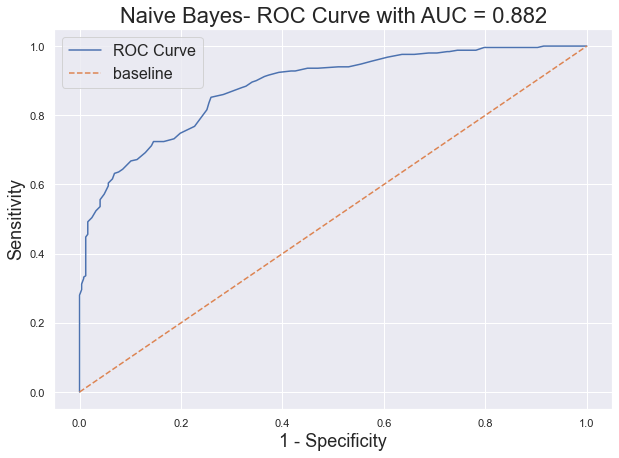

In [79]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'Naive Bayes- ROC Curve with AUC = {round(roc_auc_score(pred_df_nb["true_values"], pred_df_nb["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

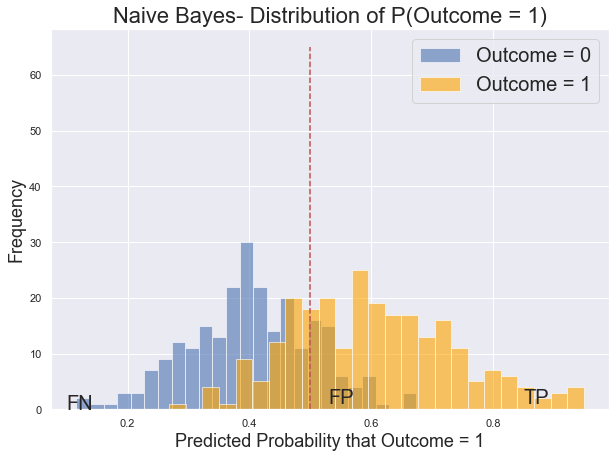

In [80]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df_nb[pred_df_nb['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df_nb[pred_df_nb['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Naive Bayes- Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Naive Bayes Classifier: Top 5 features with the highest weights

In [81]:
feature_names=np.array(tvec.get_feature_names())

In [82]:
coefs=nb.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
print(feature_names[top_five])

['hub' 'nest' 'play' 'mini' 'thi']


### Naive Bayes Classifier: Bottom 5 features with the highest weights

In [83]:
bottom_five = np.argpartition(coefs, 5)[:5]
print(feature_names[bottom_five])

['fire tv stick remot' 'firestick' 'fire tv stick' 'fire tv cube' 'firetv']


## Model 2: Logistic Regression

- Logistic regression is a linear classification method that learns the probability of a sample belonging to a certain class. Logistic regression tries to find the optimal decision boundary that best separates the classes.

In [84]:
# Instantiate logistic regression model.
lr = LogisticRegression()

# Fit model to training data.
lr.fit(train_data_features,y_train)

# Evaluate model on training data.
lr.score(train_data_features,y_train)

0.9509738079247817

In [85]:
print(f'Logistic Regression Intercept: {lr.intercept_}')
print(f'Logistic Regression Coefficient: {lr.coef_}')

Logistic Regression Intercept: [0.06263949]
Logistic Regression Coefficient: [[ 1.14491616e-01  3.18761832e-03 -1.90680744e-01 ... -3.54847584e-04
  -5.83167419e-01  1.06663947e-01]]


In [86]:
lr.score(test_data_features,y_test)

0.7987927565392354

In [87]:
lr_predictions = lr.predict(test_data_features)

In [88]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

True Negatives: 207
False Positives: 40
False Negatives: 60
True Positives: 190


#### Observation:
- Model is overfitting and we will perform hyperparameter tuning.

### Hyperparameter tuning for Logistic Regression model

In [89]:
lr_params = {
    'penalty' : ['l1', 'l2','elasticnet'],
    'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'class_weight' : [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
}

In [90]:
lr_gs= GridSearchCV(lr,param_grid=lr_params,
                    scoring='roc_auc',
                    verbose=1,
                    n_jobs=-1,cv=5)

In [91]:
lr_gs.fit(train_data_features,y_train);

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    1.8s finished


In [92]:
lr_gs.best_estimator_

LogisticRegression(C=10, class_weight={0: 0.6, 1: 0.4}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
lr_gs.best_params_

{'C': 10, 'class_weight': {1: 0.4, 0: 0.6}, 'penalty': 'l2'}

In [94]:
lr_gs.score(train_data_features,y_train)

0.9994677664956303

In [95]:
lr_gs.score(test_data_features,y_test)

0.8861862348178138

#### Observation:

- With tuning, we see a significant improvement in the accuracy of the model (post tuning: 0.886 vs pre-tuning 0.798)

In [96]:
lr_gs_predictions = lr_gs.predict(test_data_features)

In [97]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_gs_predictions).ravel()
print("True Negatives: %s" % tn)
print("False Positives: %s" % fp)
print("False Negatives: %s" % fn)
print("True Positives: %s" % tp)

cm_lr=confusion_matrix(y_test,lr_gs_predictions)
cm_lr=pd.DataFrame(cm_lr,columns=['pred AmazonEcho','pred GoogleHome'],index=['actual AmazonEcho','actual GoogleHome'])
cm_lr

True Negatives: 220
False Positives: 27
False Negatives: 81
True Positives: 169


,pred AmazonEcho,pred GoogleHome
actual AmazonEcho,220,27
actual GoogleHome,81,169


#### Observation:
- The model has 27 "False Positives" and 81 "False Negatives". 
- Type 1 error/False positives occurs when the model predicted that it's a GoogleHome post when it's actually an AmazonEcho post.
- Type 2 error/False Negative occurs when it's a 'GoogleHome' post but model classifies it as an 'AmazonEcho' post 

### Model Evaluation for Logistic Regression

In [98]:
lr_Accuracy = (tp + tn) / (tp + tn + fp + fn)
lr_Sensitivity = tp / (tp + fn)
lr_Specificity = tn / (tn + fp)
lr_Precision = tp / (tp + fp)
lr_F1_score = 2*lr_Precision*lr_Sensitivity/(lr_Precision+lr_Sensitivity)

print("Accuracy : %s" %lr_Accuracy)
print("Sensitivity : %s" %lr_Sensitivity)
print("Specificity : %s" %lr_Specificity)
print("Precision : %s" %lr_Precision)
print("F1 Score : %s" %lr_F1_score)

Accuracy : 0.7826961770623743
Sensitivity : 0.676
Specificity : 0.8906882591093117
Precision : 0.8622448979591837
F1 Score : 0.7578475336322871


#### Observation:
- Sensitivity measures the proportion of actual positives that are correctly identified while Specificity measures the proportion of actual negatives that are correctly identified.
- Sensitivity and Specificity exist in a state of balance. 
- Increased specificity – inability to identify the googlehome posts correctly comes at the expense of reduced sensitivity (lesser false-positives than false-negatives).

### ROC AUC for Logistic Regression

In [99]:
pred_proba = [i[1] for i in lr_gs.predict_proba(test_data_features)]

pred_df_ls = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

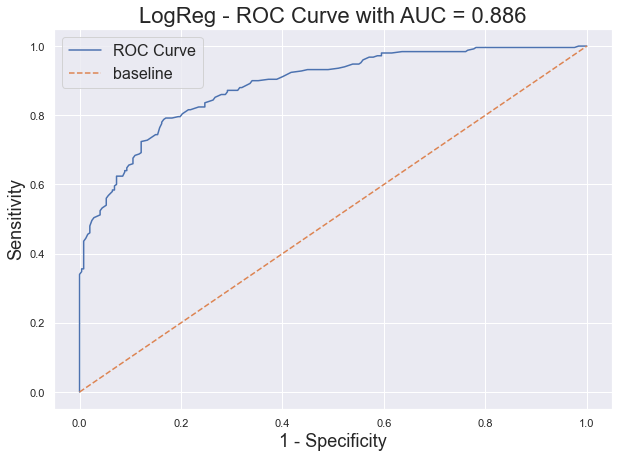

In [100]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_ls, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_ls, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'LogReg - ROC Curve with AUC = {round(roc_auc_score(pred_df_ls["true_values"], pred_df_ls["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

The more area under this blue curve is, the better separated our distributions are.

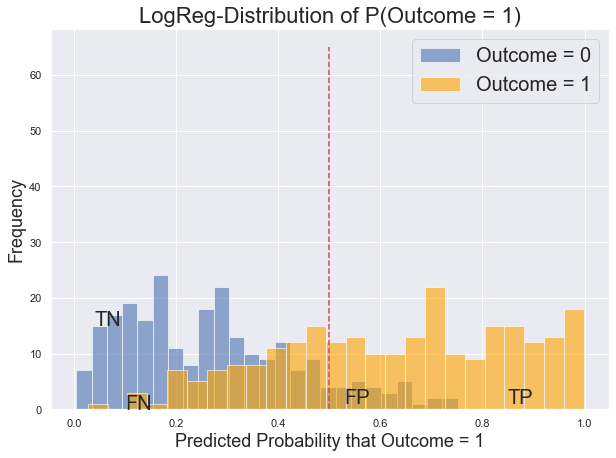

In [101]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df_ls[pred_df_ls['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Outcome = 0')
plt.hist(pred_df_ls[pred_df_ls['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 65,
           color = 'r',
           linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('LogReg-Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

### Logistic Regression: Top 5 features with the highest weights

In [102]:
feature_names=np.array(tvec.get_feature_names())

In [103]:
coefs=lr.coef_[0]
top_five = np.argpartition(coefs, -5)[-5:]
print(feature_names[top_five])

['max' 'hub' 'nest' 'assist' 'mini']


###  Logistic Regression: Bottom 5 features with the highest weights

In [104]:
bottom_five = np.argpartition(coefs, 5)[:5]
print(feature_names[bottom_five])

['skill' 'music' 'gen' 'show' 'studio']


## Evaluation:

### Comparing Logistic Regression vs Naive Bayes ROC Curve with AUC

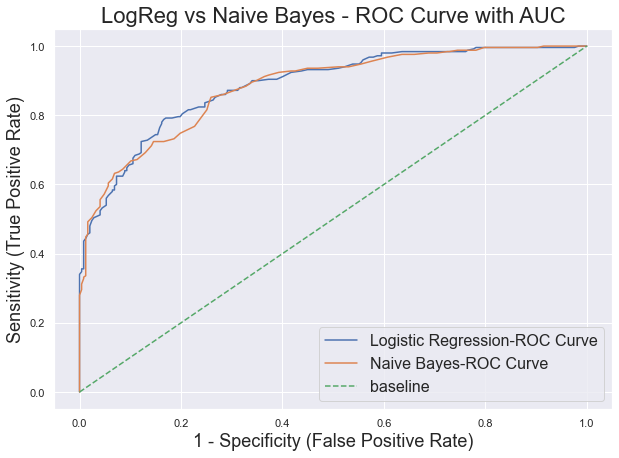

In [105]:

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df_ls, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df_ls, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='Logistic Regression-ROC Curve')



nb_tpr_values = [TPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]
nb_fpr_values = [FPR(pred_df_nb, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(nb_fpr_values, # False Positive Rate on X-axis
         nb_tpr_values, # True Positive Rate on Y-axis
         label='Naive Bayes-ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'LogReg vs Naive Bayes - ROC Curve with AUC', fontsize=22)
plt.ylabel('Sensitivity (True Positive Rate)', fontsize=18)
plt.xlabel('1 - Specificity (False Positive Rate)', fontsize=18)

# Create legend.
plt.legend(fontsize=16);


In [106]:
print('Naive Bayes- training score: ' + str(round(nb_gs.score(train_data_features,y_train),4)) + ', test score: ' + str(round(nb_gs.score(test_data_features,y_test),4)))
tn, fp, fn, tp = confusion_matrix(y_test, nb_predictions).ravel()

nb_Accuracy = (tp + tn) / (tp + tn + fp + fn)
nb_Sensitivity = tp / (tp + fn)
nb_Specificity = tn / (tn + fp)
nb_Precision = tp / (tp + fp)

print("Accuracy : %s" %nb_Accuracy)
print("Sensitivity : %s" %nb_Sensitivity)
print("Specificity : %s" %nb_Specificity)
print("Precision : %s" %nb_Precision)


print('')
print('')

print('Logistic Regression- training score: ' + str(round(lr_gs.score(train_data_features,y_train),4)) + ', test score: ' + str(round(lr_gs.score(test_data_features,y_test),4)))
tn, fp, fn, tp = confusion_matrix(y_test, lr_gs_predictions).ravel()
lr_Accuracy = (tp + tn) / (tp + tn + fp + fn)
lr_Sensitivity = tp / (tp + fn)
lr_Specificity = tn / (tn + fp)
lr_Precision = tp / (tp + fp)

print("Accuracy : %s" %lr_Accuracy)
print("Sensitivity : %s" %lr_Sensitivity)
print("Specificity : %s" %lr_Specificity)
print("Precision : %s" %lr_Precision)

Naive Bayes- training score: 0.9852, test score: 0.8818
Accuracy : 0.7766599597585513
Sensitivity : 0.748
Specificity : 0.805668016194332
Precision : 0.7957446808510639


Logistic Regression- training score: 0.9995, test score: 0.8862
Accuracy : 0.7826961770623743
Sensitivity : 0.676
Specificity : 0.8906882591093117
Precision : 0.8622448979591837


## Summary:

- Both Naive Bayes and Logistic Regression are used for classification problems.
- Both Logistic Regression and Naïve Bayes’s AUC score are relatively close (0.886 vs 0.882), thus it depends on  which trade-off we want in our model (high Precision/low Recall or low Precision/high Recall. We have chosen Logistic Regression which has lower precision and higher Recall.    
- Logistic Regression has a higher precision 0.86 (proportion of positive results that were correctly classified) as compared to Naive Bayes's 0.795.
- Naive Bayes assumes that the features are independent of each other.However, this is not always possible as real data sets are never perfectly independent and they can be close.

## Examine the misclassed data

In [119]:
df_nb = pd.DataFrame(test_data_features.toarray(),columns=tvec.get_feature_names())
df_lr = pd.DataFrame(test_data_features.toarray(),columns=tvec.get_feature_names())

In [120]:
df_nb['nb_pred']=nb_predictions
df_nb['nb_actual']=y_test.values
df_lr['lr_pred']=lr_predictions
df_lr['lr_actual']=y_test.values


# filter for the outliers
df_nb=df_nb[df_nb['nb_pred']!=df_nb['nb_actual']]
df_lr=df_lr[df_lr['lr_pred']!=df_lr['lr_actual']]

# remove all columns where there are 0 values
df_nb=df_nb.loc[:, (df_nb != 0).any(axis=0)]
df_lr=df_lr.loc[:, (df_lr != 0).any(axis=0)]

In [121]:
df_nb['nb_status']=df_nb['nb_pred'].map({1: 'fp', 0: 'fn'})
df_lr['lr_status']=df_lr['lr_pred'].map({1: 'fp', 0: 'fn'})

df_nb.drop(['nb_pred','nb_actual'],axis=1).head()
df_lr.drop(['lr_pred','lr_actual'],axis=1).head()

,abil,abl,abl control,abl play,ac,accent,access,accident,account,account link,account set,account still,account use,account wa,action,activ,actual,ad,ad group,adapt,add,add song,address,adjust,advanc,advic,ago,alarm,album,alert,allow,almost,almost everi,along,alreadi,alreadi tri,also,also tri,altern,alway,alway pick,amount,android,ani,ani advic,ani help,ani idea,ani idea fix,ani music,ani recommend,ani suggest,ani way,annoy,anoth,anoth devic,anoth room,answer,anybodi,anybodi els,anybodi know,anymor,anyon,anyon ani,anyon ani idea,anyon els,anyon els get,anyon help,anyon know,anyon know fix,anyon know fix thi,anyth,anyway,anywher,apart,app,app seem,app thi,app turn,app updat,app voic,app would,appear,appl,appl music,appl music app,appreci,appreci thank,april,area,argh,around,around thi,art,artist,ask,ask hub,ask mini,ask mini play,ask play,ask play music,ask play song,ask show,ask someth,ask specif,ask turn,ask turn tv,assign,assist,assum,audio,audio play,audiobook,auto,auto webp,autom,automat,aux,aux cabl,avail,away,back,back show,band,base,basic,becaus,becaus wa,bed,bedroom,bedroom light,bedtim,bedtim routin,beep,befor,befor get,behavior,bell,besid,better,bf,big,bit,blast,blaster,blue,bluetooth,bluetooth audio,bluetooth speaker,book,bother,bought,box,break,brick,bridg,bright,bring,broadcast,broken,browser,bt,bulb,bulb app,bunch,button,buy,cabl,calendar,call,call show,camera,cannot,cannot find,cannot get,cannot play,cant,capabl,care,case,cast,cat,caus,cd,ceil,certain,certain time,chang,chang set,chang volum,check,chime,choic,chromecast,chromecast audio,clear,clearli,clock,close,clue,code,collect,color,com,combin,come,command,command like,command play,command thi,command turn,comment,commun,compar,compat,complet,comput,condit,confirm,connect,connect account,connect app,connect devic,connect internet,connect iphon,connect network,connect speaker,connect tri,connect via,connect via bluetooth,constantli,contact,control,conveni,cord,correct,correctli,could,coupl,coupl year,cover,crazi,creat,creat new,creat playlist,current,custom,custom command,custom routin,cut,cycl,daili,data,daughter,day,deactiv,dead,decent,decid,default,default music,delet,demo,design,desir,detail,devic,devic connect,devic drop,devic even,devic name,devic onli,devic room,devic seem,devic set,devic show,devic spotifi,devic thi,devic tri,devic work,didnt,die,differ,differ room,differ song,digit,dim,dim light,direct,disabl,disappear,discov,display,doe,doe anybodi,doe anybodi know,doe anyon,doe anyon know,doe anyon know fix,doe work,dont,door,door open,doorbel,doubl,dr,drop,dure,dure thi,earlier,easier,ecosystem,edit,either,els,els get,els thi,email,empti,en,enabl,end,enjoy,enough,entir,entri,episod,eq,error,especi,etc,even,even possibl,even though,ever,everi,everi day,everi hour,everi singl,everi time,everyday,everyon,everyon ha,everyth,everyth work,everywher,exactli,exampl,except,exist,experi,extern,extra,fact,factori,factori reset,fail,fall,famili,famili account,famili room,fan,far,featur,feel,feel like,fi,figur,final,find,find anyth,find devic,fine,first,first one,first song,first time,fix,fix issu,fix thi,fix thi issu,fixtur,floor,follow,forc,forget,format,format pjpg,format pjpg auto,format pjpg auto webp,found,found thi,freak,french,front,frustrat,function,futur,galaxi,game,gen,gener,german,get,get audio,get better,get new,get play,get play music,get thi,give,give command,give thi,glitch,go,go app,go thi,goe,gone,good,good morn,goodnight,goodnight routin,got,grandpar,great,greatli,greatli appreci,group,group call,group name,group play,guess,guy,guy think,ha,ha anyon,ha happen,ha speaker,ha thi,happen,happen devic,happen everi,happen play,hard,hard reset,hear,heard,heat,hello,hello everyon,help,help pleas,help set,help thank,help thi,help us,hey,hey guy,hi,hi everyon,hi recent,high,hook,hour,hous,household,howev,http,http imgur,http imgur com,http preview,http preview redd,http www,http www reddit,http www reddit com,hub,hub play,hue,hue app,hue bridg,icon,id,

#### Checks for False Positives in Naive Bayes

In [114]:
df_nb_fp=df_nb[df_nb['nb_status']=='fp']
df_nb_fp=df_nb_fp.loc[:, (df_nb_fp != 0).any(axis=0)]
df_nb_fp_=pd.DataFrame(df_nb_fp.sum(axis = 0, skipna = True),columns=['count'])
df_nb_fp_.drop(['nb_pred','nb_status'],inplace=True)
df_nb_fp_.sort_values(by='count',ascending=False).head(10)

,count
room,1.82823
turn,1.72703
light,1.68859
wa,1.61166
time,1.56764
devic,1.56374
thi,1.48261
tri,1.33009
remind,1.27332
door,1.15983


#### Checks for False Positives in Logistic Regression

In [115]:
df_lr_fp=df_lr[df_lr['lr_status']=='fp']
df_lr_fp=df_lr_fp.loc[:, (df_lr_fp != 0).any(axis=0)]
df_lr_fp_=pd.DataFrame(df_lr_fp.sum(axis = 0, skipna = True),columns=['count'])
df_lr_fp_.drop(['lr_pred','lr_status'],inplace=True)
df_lr_fp_.sort_values(by='count',ascending=False).head(10)

,count
turn,1.55273
room,1.34676
door,1.15983
work,1.09849
connect,1.09759
plug,1.06223
rhyme,1
find,0.99455
wa,0.986882
speaker,0.96339


#### Checks for False Negatives in Naive Bayes

In [116]:
df_nb_fn=df_nb[df_nb['nb_status']=='fn']
df_nb_fn=df_nb_fn.loc[:, (df_nb_fn != 0).any(axis=0)]
df_nb_fn_=pd.DataFrame(df_nb_fn.sum(axis = 0, skipna = True),columns=['count'])
df_nb_fn_.drop(['nb_actual','nb_status'],inplace=True)
df_nb_fn_.sort_values(by='count',ascending=False).head(10)

,count
play,4.27738
music,3.21243
one,2.23917
routin,2.22537
light,1.89868
speaker,1.89425
group,1.79432
ani,1.76191
start,1.72536
thi,1.72502


#### Checks for False Negatives in Logistic Regression

In [117]:
df_lr_fn=df_lr[df_lr['lr_status']=='fn']
df_lr_fn=df_lr_fn.loc[:, (df_lr_fn != 0).any(axis=0)]
df_lr_fn_=pd.DataFrame(df_lr_fn.sum(axis = 0, skipna = True),columns=['count'])
df_lr_fn_.drop(['lr_actual','lr_status'],inplace=True)
df_lr_fn_.sort_values(by='count',ascending=False).head(10)

,count
play,3.51781
music,3.06831
routin,2.71454
light,1.99921
thi,1.80363
ani,1.72632
show,1.63058
turn,1.62984
tri,1.60013
speaker,1.59238


### Findings:

- After conducting the review for the misclassified words, it seems these words that exists in both posts are common in smart devices. eg. play, music, room, turn...

- We can include the common words in the stop words list to achieve a better accuracy. However we will refrain from that since we may be classifiying it against other non-smart devices sub posts.  

## Conclusion:

In this project, we are trying to build a model that is able to classify the GoogleHome post (Positive class) from a AmazonEcho post (Negative Class). We have used Naive Bayes Classifier and Logistic Regression with hyperparameter tuning to improve the performnce of our model. To generalise the model, we have included distinct keywords such as google, home, alexa, echo, amazon in the stop words list. We have chosen Logistic Regression as highlighted in the summary above. From the review conducted for the misclassed features, we are of the view that because we are comparing between 2 smart devices, there will be overlapping words. Despite that, we are still able to achieve a good accuracy score for our selected classifier model.   